In [186]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import itertools

In [187]:
df_train = pd.read_csv('./anomaly_detection_dataset_2022/trainset.csv')
df_anomaly = pd.read_csv('./anomaly_detection_dataset_2022/anomaly_testset1.csv')

df_train['created_at'] = pd.to_datetime(df_train['created_at'])
df_anomaly['created_at'] = pd.to_datetime(df_anomaly['created_at'])

df_train = df_train.drop(columns=['created_at'])
df_anomaly = df_anomaly.drop(columns=['created_at', 'scene', 'label'])

In [188]:
# fit scaler, fitted on the train data
scaler = StandardScaler()
scaler.fit(df_train)
scaled_train_data = scaler.transform(df_train)

# fit k-means, fitted on the scaled train data
kmeans = KMeans(n_clusters=10)
kmeans.fit(scaled_train_data)

# fit PCA, fitted on the scaled train data
pca = PCA(n_components=2)
pca.fit(scaled_train_data)

PCA(n_components=2)

In [189]:
# cluster the data sets
scaled_train_data = scaler.transform(df_train)
train_clusters = kmeans.predict(scaled_train_data)
df_train['cluster'] = train_clusters

scaled_anomalous_data = scaler.transform(df_anomaly)
anomalous_clusters = kmeans.predict(scaled_anomalous_data)
df_anomaly['cluster'] = anomalous_clusters

In [190]:
pca_train_data = pca.transform(scaled_train_data)
pca_anomaly_data = pca.transform(scaled_anomalous_data)



In [191]:
train_clusters.shape

(45395,)

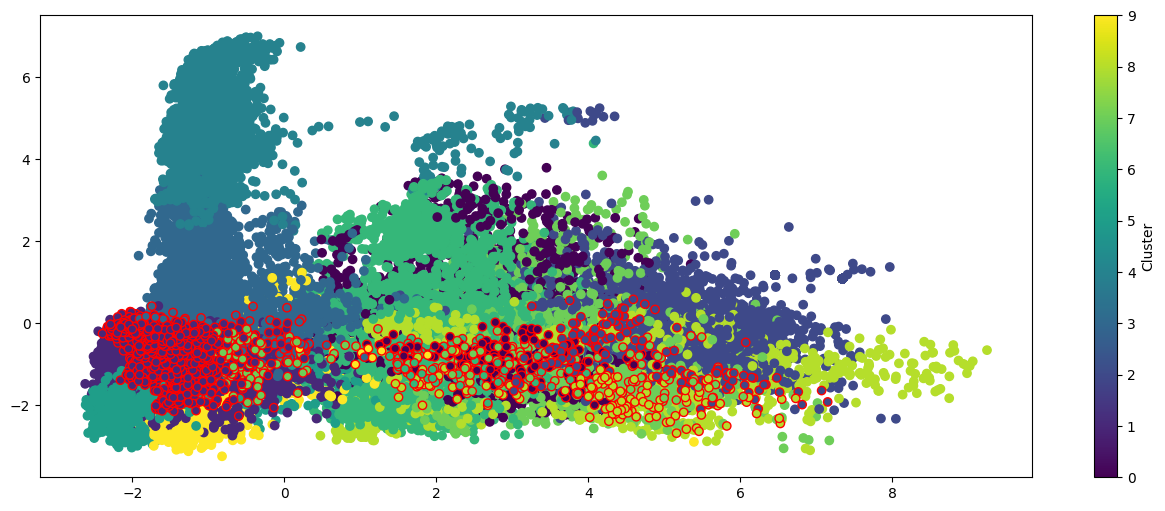

In [192]:
plt.figure(figsize=(16,6))
plt.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c=train_clusters, cmap='viridis', edgecolors=None, alpha=1)
plt.scatter(pca_anomaly_data[:, 0], pca_anomaly_data[:, 1], c=anomalous_clusters, cmap='viridis', edgecolors='red')
plt.colorbar(label='Cluster')
plt.show()

In [206]:
# detect anomaly using distances from clusters

# for each point, compute distance to cluster
train_distances = kmeans.transform(scaled_train_data)
anomalous_distances = kmeans.transform(scaled_anomalous_data)
df_train['distance_to_cluster'] = np.mean(train_distances, axis=1)
df_anomaly['distance_to_cluster'] = np.min(anomalous_distances, axis=1)

# compute thresholds for each cluster
thresholds = {}
for cluster in range(kmeans.n_clusters):
    # get distances for cluster
    cluster_distances = df_train[df_train['cluster'] == cluster]['distance_to_cluster']

    # find threshold for the cluster
    thresholds[cluster] = np.percentile(cluster_distances, 95)

print(thresholds)

{0: 6.952409467020131, 1: 5.4221543182406995, 2: 8.679021254015726, 3: 5.9492633064524485, 4: 7.838238572868433, 5: 5.6114726139556375, 6: 6.376857885423668, 7: 8.101115210584984, 8: 10.426418188615173, 9: 6.630618879017179}


In [225]:
detected_data = df_anomaly[
    df_anomaly.apply(lambda row: row['distance_to_cluster'] > thresholds[row['cluster']], axis=1)
]

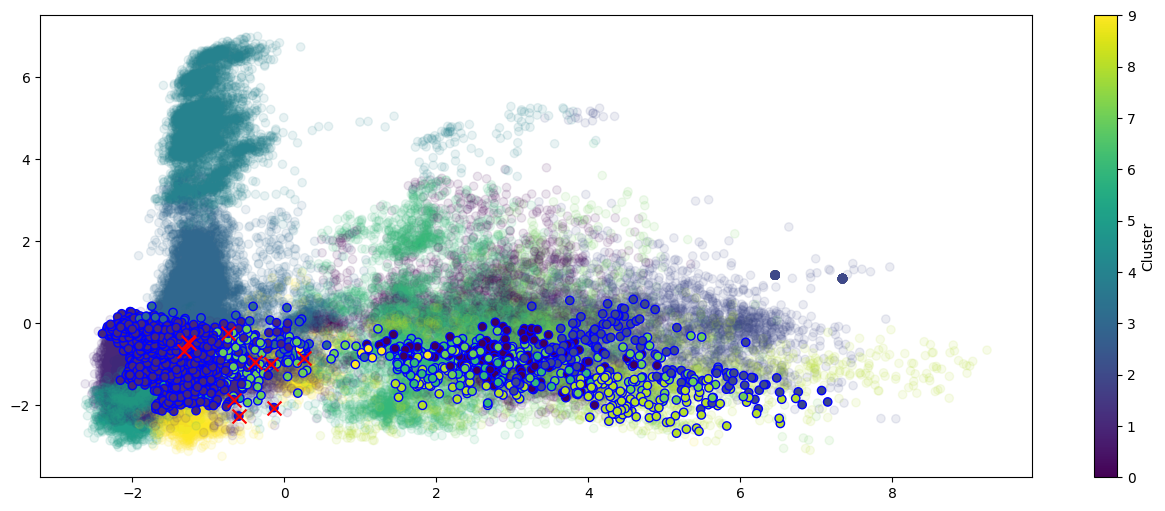

In [233]:
scaled_detected_data = scaler.transform(detected_data.drop(columns=['cluster', 'distance_to_cluster']))
pca_detected_data = pca.transform(scaled_detected_data)


plt.figure(figsize=(16,6))
train_scatter = plt.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c=train_clusters, cmap='viridis', edgecolors=None, alpha=1)
train_scatter.set_alpha(0.1)

plt.scatter(pca_anomaly_data[:, 0], pca_anomaly_data[:, 1], c=anomalous_clusters, cmap='viridis', edgecolors='blue')
plt.colorbar(label='Cluster')

plt.scatter(pca_detected_data[:, 0], pca_detected_data[:, 1], color='red', marker='x', alpha=1, s=100)


plt.show()